In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gf2_dependent_subset(sel, M):
    """
    Single-pass GF(2) rank + dependency detection with micro-optimizations:
      * Use argmax to find pivots.
      * Minimize per-loop overhead.
      * Process selected rows first, then candidate rows.

    Parameters
    ----------
    sel : boolean array of shape (n,)
        Indicator for which rows are selected.
    M   : boolean array of shape (n, c)
        GF(2) matrix.

    Returns
    -------
    rank_val : int
        Rank of the submatrix formed by selected rows.
    dep : boolean array of shape (n,)
        For each row k not selected (sel[k]==False), dep[k] == True if that row
        is in the span of the selected rows.
    """
    # Ensure boolean arrays
    sel = np.asarray(sel, dtype=bool)
    M   = np.asarray(M,   dtype=bool)
    n   = M.shape[0]

    # Indices of selected and candidate rows
    sel_idx  = np.flatnonzero(sel)
    cand_idx = np.flatnonzero(~sel)
    num_sel  = sel_idx.size
    num_cand = cand_idx.size

    # If no rows selected, rank is 0 and no dependencies
    if num_sel == 0:
        return 0, np.zeros(n, dtype=bool)

    # Build top block: selected rows of M
    A = M[sel_idx, :]
    top_count = A.shape[0]

    # Build bottom block: candidate rows of M (empty if none)
    C = M[cand_idx, :] if num_cand > 0 else np.zeros((0, M.shape[1]), dtype=bool)
    bottom_count = C.shape[0]

    # Combine blocks into one matrix for elimination
    B = np.vstack((A, C))
    row_count, col_count = B.shape

    # Perform Gaussian elimination over GF(2)
    pivot_row = 0
    for col in range(col_count):
        if pivot_row >= top_count:
            break

        subcol = B[pivot_row:top_count, col]
        pivot_offset = subcol.argmax()
        if not subcol[pivot_offset]:
            continue

        pivot_idx = pivot_row + pivot_offset
        if pivot_idx != pivot_row:
            B[[pivot_row, pivot_idx]] = B[[pivot_idx, pivot_row]]

        # Eliminate 1s below the pivot in this column
        if pivot_row < row_count - 1:
            below = B[pivot_row + 1:, col]
            rows_to_xor = np.flatnonzero(below) + (pivot_row + 1)
            if rows_to_xor.size > 0:
                B[rows_to_xor] ^= B[pivot_row]

        pivot_row += 1

    rank_val = pivot_row

    # Determine which candidate rows are in the span (zero rows after elimination)
    dep = np.zeros(n, dtype=bool)
    if bottom_count > 0 and rank_val > 0:
        candidate_block = B[top_count:]
        dep_mask = ~candidate_block.any(axis=1)
        dep[cand_idx[dep_mask]] = True

    return rank_val, dep

In [3]:
def apply_inference_rules(V: np.ndarray, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """
    Given:
        V: 1D binary array of length W (known vars marked 1)
        X: 2D binary array of shape (R, W) (rule antecedents)
        Y: 2D binary array of shape (R, W) (rule consequents)

    Returns:
        A binary vector of length W containing newly inferred vars:
          - For each rule i, if all X[i,j]==1 ⇒ V[j]==1, the rule is 'satisfied'.
          - OR together all Y[i] for satisfied rules.
          - Zero out any positions already 1 in V.
    """
    # 1) Check antecedents: rule i is satisfied if X[i] <= V elementwise
    #    i.e. wherever X[i]==1, V must also be 1.
    #    (X & ~V) will be 1 where X demands a var that V doesn't know; so we want no such bits.
    violated = (X & (~V.astype(bool))).any(axis=1)
    satisfied = ~violated

    # 2) Build binary vector of satisfied rules (optional to return if needed)
    #    sat_vec = satisfied.astype(int)

    # 3) OR together the consequents Y for satisfied rules
    if satisfied.any():
        or_result = np.any(Y[satisfied], axis=0)
    else:
        or_result = np.zeros_like(V, dtype=bool)

    # 4) Zero out positions already known in V
    new_inferences = or_result & (~V.astype(bool))

    # 5) Return as int array
    return new_inferences.astype(int)


In [4]:
def fill_inferable_symbols(curvect,fullsystem,antecedents,consequents):

    curvect = curvect.copy()
    
    pastlinear = 0
    curlinear = curvect.sum()

    pastnonlinear = 0
    curnonlinear = curvect.sum()

    while pastlinear != curlinear or pastnonlinear != curnonlinear:
        if pastlinear != curlinear:
            rank,infervect = gf2_dependent_subset(curvect,fullsystem)
            curvect = np.maximum(curvect,infervect)

            pastlinear = curlinear
            curlinear = curvect.sum()
            curnonlinear = curvect.sum()
            pastlinear = curlinear # since linear never needs to be run twice in a row
            
        if pastnonlinear != curnonlinear:
            infervect = apply_inference_rules(curvect,antecedents,consequents)
            curvect = np.maximum(curvect,infervect)

            pastnonlinear = curnonlinear
            curlinear = curvect.sum()
            curnonlinear = curvect.sum()
            
    return curvect 

In [5]:
matrices = np.load('inference_matrices.npz')
solution = matrices['solution']
fullsystem = matrices['fullsystem']
antecedents = matrices['antecedents']
consequents = matrices['consequents']

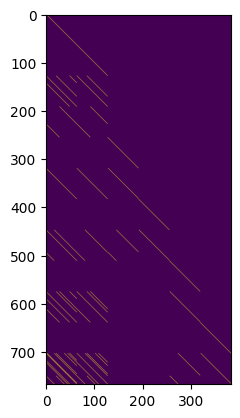

In [6]:
plt.imshow(fullsystem)

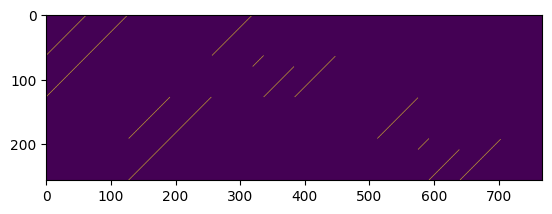

In [7]:
plt.imshow(antecedents)

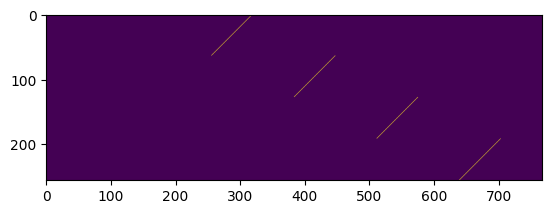

In [8]:
plt.imshow(consequents)

In [9]:
filled = fill_inferable_symbols(solution,fullsystem,antecedents,consequents)

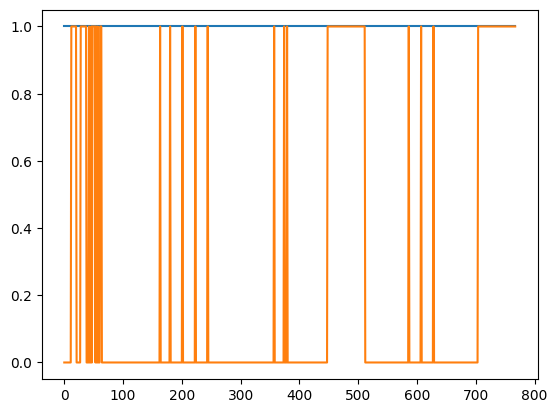

In [10]:
plt.plot(filled)
plt.plot(solution)